# 03 - Regression Modeling

## 1. Import Packages <a name="import"></a>

In [1]:
import pandas as pd
import numpy as np

import pprint as pp

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import statsmodels.api as sm

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV

from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

## Table of Contents <a name="table"></a>
1. [Import Packages](#import)
2. [Transforming Data](#transform)
3. [Standardization](#scale)
4. [Feature Engineering](#feature)
5. [Cross-Validation](#val)
    1. [Regular](#reg)
    2. [LASSO](#lasso)
    3. [Ridge](#ridge)
5. [Results](#results)   

## 2. Transforming Data <a name="transform"></a>

"altmetric" should be log-transformed since it is non-negative and count-like<br>
"num_times_cited", "num_institutions", and "num_authors" could be log-transformed for better model performance.

In [219]:
#import the data
combined = pd.read_pickle('./data/combined_article_metrics.pkl') 
combined.head()

,title_length,altmetric,num_times_cited,abstract_length,page_length,fig_count,ref_cnt,num_authors,top100,other,num_institutions,year
0,12,0,112,68,5,6,47,9,1,1,2,10
1,8,6,112,59,5,8,42,5,1,1,5,10
2,10,24,551,62,5,7,38,33,0,1,9,10
3,9,33,647,51,7,10,52,14,0,1,12,10
4,7,1,473,57,5,10,49,6,1,1,2,10


In [220]:
#original model
df = combined.copy()
X, y = df.drop(columns = ['altmetric']), df['altmetric']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42)
X_train = sm.add_constant(X_train, has_constant='add') #something already has a variance of 0
model = sm.OLS(y_train, X_train)

fit = model.fit()

X_test = sm.add_constant(X_test, has_constant='add') 
y_pred = fit.predict(X_test)
print('R^2 Score for Test: ' + str(round(r2_score(y_test, y_pred), 2)))

fit.summary()

R^2 Score for Test: 0.13


/home/kchiv/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              altmetric   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     21.48
Date:                Mon, 09 Mar 2020   Prob (F-statistic):           2.77e-37
Time:                        15:59:16   Log-Likelihood:                -9261.9
No. Observations:                1266   AIC:                         1.855e+04
Df Residuals:                    1255   BIC:                         1.860e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              251.3673     46.189      5.442      0.000     160.750     341.984
title_length         6.6093      5.471      1.208      0.227      -4.125      17.344
num_times_cited      0.1441      0.026      5.559      0.000       0.093       0.195
abstract_length     -0.4140      0.302     -1.370      0.171      -1.007       0.179
page_length         -2.4681     13.284     -0.186      0.853     -28.530      23.594
fig_count           -4.8306      4.410     -1.095      0.274     -13.482       3.821
ref_cnt             -1.0856      0.598     -1.815      0.070      -2.259       0.088
num_authors          1.1146      0.466      2.392      0.017       0.201       2.029
top100              -3.7508     21.209     -0.177      0.860     -45.359      37.857
other              251.3673     46.189      5.442      0.000     160.750     341.984
num_institutions    -0.3923      0.789     -0.497      0.619      -1.940       1.156
year               -55.6676      4.183    -13.309      0.000     -63.874     -47.462
==============================================================================
Omnibus:                     1399.958   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            99336.114
Skew:                           5.506   Prob(JB):                         0.00
Kurtosis:                      44.975   Cond. No.                     2.58e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.25e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The initial model has a rather low $R^2$ value. <br>
We first address heteroskedasticity by addressing outliers in the target variable. <br>
The score does improve quite a bit.

In [221]:
#original model with less outliers in target variable

df = combined.copy()
q1 = combined['altmetric'].quantile(.25)
q3 = combined['altmetric'].quantile(.75)
iqr = q3 - q1

lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr)

quartile_mask = df['altmetric'].between(lower_bound, upper_bound, inclusive=True)
allowed_idx = df.loc[quartile_mask, 'altmetric'].index
df = df[df.index.isin(allowed_idx)]

X, y = df.drop(columns = ['altmetric']), df['altmetric']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42)
X_train = sm.add_constant(X_train, has_constant='add') #something already has a variance of 0
model = sm.OLS(y_train, X_train)

fit = model.fit()

X_test = sm.add_constant(X_test, has_constant='add') 
y_pred = fit.predict(X_test)
print('R^2 Score for Test: ' + str(round(r2_score(y_test, y_pred), 2)))

fit.summary()

R^2 Score for Test: 0.29


/home/kchiv/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              altmetric   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     64.74
Date:                Mon, 09 Mar 2020   Prob (F-statistic):          5.80e-104
Time:                        15:59:21   Log-Likelihood:                -6727.6
No. Observations:                1140   AIC:                         1.348e+04
Df Residuals:                    1129   BIC:                         1.353e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               79.8449     12.197      6.546      0.000      55.914     103.776
title_length         0.8535      1.424      0.599      0.549      -1.940       3.647
num_times_cited      0.0552      0.008      7.315      0.000       0.040       0.070
abstract_length      0.1558      0.078      2.002      0.046       0.003       0.308
page_length          2.2308      3.496      0.638      0.524      -4.629       9.090
fig_count           -2.2519      1.124     -2.004      0.045      -4.457      -0.047
ref_cnt              0.2969      0.152      1.958      0.050      -0.001       0.594
num_authors          0.8342      0.146      5.721      0.000       0.548       1.120
top100              21.7643      5.398      4.032      0.000      11.173      32.356
other               79.8449     12.197      6.546      0.000      55.914     103.776
num_institutions    -0.0734      0.266     -0.275      0.783      -0.596       0.449
year               -21.4258      1.104    -19.409      0.000     -23.592     -19.260
==============================================================================
Omnibus:                      283.154   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              640.208
Skew:                           1.361   Prob(JB):                    9.56e-140
Kurtosis:                       5.463   Cond. No.                     3.17e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.89e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Moving forward, we will make sure to use interquartile range to filter the target variable first.

In [222]:
q1 = combined['altmetric'].quantile(.25)
q3 = combined['altmetric'].quantile(.75)
iqr = q3 - q1

lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr)

quartile_mask = combined['altmetric'].between(lower_bound, upper_bound, inclusive=True)
allowed_idx = combined.loc[quartile_mask, 'altmetric'].index
combined = combined[combined.index.isin(allowed_idx)]

The results improve from a log transform of the dependent variable. <br>
However, the test score is worse than the train score due to multi-collinearity.

In [223]:
#log model

df = combined.copy()
X, y = df.drop(columns = ['altmetric']), df['altmetric']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42)
X_train = sm.add_constant(X_train, has_constant='add') #something already has a variance of 0
model = sm.OLS(np.log(y_train+1), X_train)

X_test = sm.add_constant(X_test, has_constant='add') 
y_pred = fit.predict(X_test)
print('R^2 Score for Test: ' + str(round(r2_score(y_test, y_pred), 2)))

fit = model.fit() 
fit.summary()

R^2 Score for Test: 0.29


/home/kchiv/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              altmetric   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     116.9
Date:                Mon, 09 Mar 2020   Prob (F-statistic):          1.61e-166
Time:                        15:59:27   Log-Likelihood:                -1510.7
No. Observations:                1140   AIC:                             3043.
Df Residuals:                    1129   BIC:                             3099.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.8892      0.126     23.012      0.000       2.643       3.136
title_length        -0.0182      0.015     -1.245      0.213      -0.047       0.011
num_times_cited      0.0010   7.77e-05     12.465      0.000       0.001       0.001
abstract_length     -0.0017      0.001     -2.108      0.035      -0.003      -0.000
page_length          0.0015      0.036      0.041      0.967      -0.069       0.072
fig_count           -0.0068      0.012     -0.586      0.558      -0.029       0.016
ref_cnt             -0.0010      0.002     -0.623      0.533      -0.004       0.002
num_authors          0.0092      0.002      6.158      0.000       0.006       0.012
top100               0.2087      0.056      3.755      0.000       0.100       0.318
other                2.8892      0.126     23.012      0.000       2.643       3.136
num_institutions    -0.0057      0.003     -2.076      0.038      -0.011      -0.000
year                -0.3406      0.011    -29.972      0.000      -0.363      -0.318
==============================================================================
Omnibus:                       14.222   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.131
Skew:                          -0.204   Prob(JB):                     0.000314
Kurtosis:                       3.416   Cond. No.                     3.17e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.89e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The results further improved from taking the log transform of 'num_times_cited', 'num_institutions', and 'num_authors'.

In [224]:
#log model with scaled and log-transformed independent variables

df = combined.copy()
log_cols = ['altmetric', 'num_times_cited', 'num_institutions', 'num_authors']

for col in log_cols:
    if col == 'altmetric':
        df[col] = np.log(df[col] + 1)
    else:
        df[col] = np.log(df[col])

X, y = df.drop(columns = ['altmetric']), df['altmetric']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42)
X_train = sm.add_constant(X_train, has_constant='add') #something already has a variance of 0
model = sm.OLS(y_train, X_train)


fit = model.fit() 

X_test = sm.add_constant(X_test, has_constant='add') 
y_pred = fit.predict(X_test)
print('R^2 Score for Test: ' + str(round(r2_score(y_test, y_pred), 2)))

fit.summary()

R^2 Score for Test: 0.52


/home/kchiv/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              altmetric   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     138.8
Date:                Mon, 09 Mar 2020   Prob (F-statistic):          1.05e-188
Time:                        15:59:43   Log-Likelihood:                -1458.8
No. Observations:                1140   AIC:                             2940.
Df Residuals:                    1129   BIC:                             2995.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.7712      0.126     14.105      0.000       1.525       2.018
title_length        -0.0139      0.014     -0.987      0.324      -0.042       0.014
num_times_cited      0.4848      0.033     14.489      0.000       0.419       0.550
abstract_length      0.0009      0.001      1.187      0.236      -0.001       0.003
page_length          0.0022      0.033      0.067      0.947      -0.062       0.067
fig_count            0.0065      0.011      0.587      0.557      -0.015       0.028
ref_cnt             -0.0029      0.001     -1.974      0.049      -0.006   -1.79e-05
num_authors          0.1052      0.038      2.772      0.006       0.031       0.180
top100               0.1162      0.055      2.098      0.036       0.008       0.225
other                1.7712      0.126     14.105      0.000       1.525       2.018
num_institutions     0.1217      0.041      2.986      0.003       0.042       0.202
year                -0.4078      0.014    -29.971      0.000      -0.435      -0.381
==============================================================================
Omnibus:                       11.122   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               15.016
Skew:                          -0.100   Prob(JB):                     0.000549
Kurtosis:                       3.526   Cond. No.                     5.55e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.5e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Return to [Table of Contents](#table)

## 3. Standardization <a name="scale"></a>

We will only scale the non-categorical independent variables and combine it back with our categorical data.

In [225]:
#log model with scaled and log-transformed independent variables

df = combined.copy()
log_cols = ['altmetric', 'num_times_cited', 'num_institutions', 'num_authors']

for col in log_cols:
    if col == 'altmetric':
        df[col] = np.log(df[col] + 1)
    else:
        df[col] = np.log(df[col])
        
X, y = df.drop(columns = ['altmetric']), df['altmetric']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42)


#scale only the non-categorical columns
cat_cols = ['top100', 'other']
scaled_cols = X_train.columns[~X_train.columns.isin(cat_cols)]

scaler = StandardScaler()

#drop the columns to be scaled to make reassigning easier
X_train, scaled_train_cols = X_train.drop(columns = scaled_cols), \
                                scaler.fit_transform(X_train[scaled_cols])

X_test, scaled_test_cols = X_test.drop(columns = scaled_cols), \
                                scaler.transform(X_test[scaled_cols])

#recreate the columns with the scaled values
#while making sure to reassign at the correct index
X_train[scaled_cols] = pd.DataFrame(scaled_train_cols,
                                    index = X_train.index,
                                    columns = scaled_cols)

X_test[scaled_cols] = pd.DataFrame(scaled_test_cols,
                                   index = X_test.index,
                                   columns = scaled_cols)


#something already has a variance of 0
X_train = sm.add_constant(X_train, has_constant='add') 

model = sm.OLS(y_train, X_train)

fit = model.fit()

X_test = sm.add_constant(X_test, has_constant='add') 
y_pred = fit.predict(X_test)
print('R^2 Score for Test: ' + str(round(r2_score(y_test, y_pred), 2)))

fit.summary()

R^2 Score for Test: 0.52


/home/kchiv/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              altmetric   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     138.8
Date:                Mon, 09 Mar 2020   Prob (F-statistic):          1.05e-188
Time:                        16:00:01   Log-Likelihood:                -1458.8
No. Observations:                1140   AIC:                             2940.
Df Residuals:                    1129   BIC:                             2995.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.0102      0.019    108.150      0.000       1.974       2.047
top100               0.1162      0.055      2.098      0.036       0.008       0.225
other                2.0102      0.019    108.150      0.000       1.974       2.047
title_length        -0.0259      0.026     -0.987      0.324      -0.077       0.026
num_times_cited      0.5907      0.041     14.489      0.000       0.511       0.671
abstract_length      0.0380      0.032      1.187      0.236      -0.025       0.101
page_length          0.0019      0.028      0.067      0.947      -0.054       0.058
fig_count            0.0182      0.031      0.587      0.557      -0.043       0.079
ref_cnt             -0.0537      0.027     -1.974      0.049      -0.107      -0.000
num_authors          0.1005      0.036      2.772      0.006       0.029       0.172
num_institutions     0.1181      0.040      2.986      0.003       0.040       0.196
year                -1.1635      0.039    -29.971      0.000      -1.240      -1.087
==============================================================================
Omnibus:                       11.122   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               15.016
Skew:                          -0.100   Prob(JB):                     0.000549
Kurtosis:                       3.526   Cond. No.                     1.03e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.47e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

As it turns out, "top100" had multi-collinearity with the intercept due it having 0 variance. <br>
Removing that fixed the issues. <br>
Features with low statistical significance i.e. high p-values were also removed.

In [227]:
#log model with fewer scaled and log-transformed independent variables

df = combined.copy()
log_cols = ['altmetric', 'num_times_cited', 'num_institutions', 'num_authors']

for col in log_cols:
    if col == 'altmetric':
        df[col] = np.log(df[col] + 1)
    else:
        df[col] = np.log(df[col])

drop_cols = ['altmetric','other', 'top100', 'title_length', 
             'abstract_length','page_length', 'fig_count']        
        
X, y = df.drop(columns = drop_cols), df['altmetric']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42)

#scale data
scaler = StandardScaler()

#only fit_transform on train set, transform on test
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#something already has a variance of 0
X_train = sm.add_constant(X_train, has_constant='add') 

model = sm.OLS(y_train, X_train)

fit = model.fit()

X_test = sm.add_constant(X_test, has_constant='add') 
y_pred = fit.predict(X_test)
print('R^2 Score for Test: ' + str(round(r2_score(y_test, y_pred), 2)))

fit.summary()

R^2 Score for Test: 0.52


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              altmetric   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     275.0
Date:                Mon, 09 Mar 2020   Prob (F-statistic):          1.22e-192
Time:                        16:00:12   Log-Likelihood:                -1463.3
No. Observations:                1140   AIC:                             2939.
Df Residuals:                    1134   BIC:                             2969.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0763      0.026    157.164      0.000       4.025       4.127
x1             0.5717      0.038     15.173      0.000       0.498       0.646
x2            -0.0578      0.027     -2.149      0.032      -0.111      -0.005
x3             0.0934      0.036      2.595      0.010       0.023       0.164
x4             0.1493      0.037      4.045      0.000       0.077       0.222
x5            -1.1667      0.038    -30.475      0.000      -1.242      -1.092
==============================================================================
Omnibus:                        9.463   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               12.258
Skew:                          -0.093   Prob(JB):                      0.00218
Kurtosis:                       3.473   Cond. No.                         2.64
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Return to [Table of Contents](#table)

## 4. Feature Engineering <a name="feature"></a>

Here we try some feature engineering as well with PolynomialFeatures. <br>
The results offer a modest improvement, but not enough to justify its use.

In [228]:
df = combined.copy()
log_cols = ['altmetric', 'num_times_cited', 'num_institutions', 'num_authors']

for col in log_cols:
    if col == 'altmetric':
        df[col] = np.log(df[col] + 1)
    else:
        df[col] = np.log(df[col])

drop_cols = ['altmetric','other', 'top100', 'title_length', 
             'abstract_length','page_length', 'fig_count']        
        
X, y = df.drop(columns = drop_cols), df['altmetric']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42)


#scale data and generate new features
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)

#only fit_transform on train set, transform on test
X_train = scaler.fit_transform(X_train)
X_train = poly.fit_transform(X_train)

X_test = scaler.transform(X_test)
X_test = poly.transform(X_test)

#something already has a variance of 0
X_train = sm.add_constant(X_train, has_constant='add') 


model = sm.OLS(y_train, X_train)

fit = model.fit() 
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              altmetric   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     79.05
Date:                Mon, 09 Mar 2020   Prob (F-statistic):          1.21e-197
Time:                        16:00:21   Log-Likelihood:                -1413.8
No. Observations:                1140   AIC:                             2870.
Df Residuals:                    1119   BIC:                             2975.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0517      0.023     90.095      0.000       2.007       2.096
x1             2.0517      0.023     90.095      0.000       2.007       2.096
x2             0.5497      0.042     13.161      0.000       0.468       0.632
x3            -0.1640      0.037     -4.462      0.000      -0.236      -0.092
x4             0.1048      0.047      2.213      0.027       0.012       0.198
x5             0.1059      0.047      2.241      0.025       0.013       0.199
x6            -1.1223      0.041    -27.566      0.000      -1.202      -1.042
x7             0.0133      0.038      0.354      0.723      -0.060       0.087
x8             0.0988      0.051      1.946      0.052      -0.001       0.198
x9             0.0861      0.054      1.597      0.111      -0.020       0.192
x10           -0.1144      0.053     -2.171      0.030      -0.218      -0.011
x11            0.2440      0.069      3.555      0.000       0.109       0.379
x12           -0.0045      0.005     -0.820      0.413      -0.015       0.006
x13            0.0272      0.050      0.542      0.588      -0.071       0.126
x14           -0.0072      0.046     -0.158      0.874      -0.097       0.083
x15           -0.2476      0.055     -4.516      0.000      -0.355      -0.140
x16            0.0803      0.032      2.515      0.012       0.018       0.143
x17           -0.0755      0.035     -2.134      0.033      -0.145      -0.006
x18           -0.1162      0.059     -1.982      0.048      -0.231      -0.001
x19            0.0081      0.033      0.247      0.805      -0.056       0.073
x20            0.0990      0.057      1.726      0.085      -0.014       0.212
x21           -0.2815      0.045     -6.215      0.000      -0.370      -0.193
==============================================================================
Omnibus:                       10.636   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               14.088
Skew:                          -0.101   Prob(JB):                     0.000873
Kurtosis:                       3.506   Cond. No.                     3.13e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.22e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Return to [Table of Contents](#table)

## 5. Cross-Validation <a name="val"></a>

In [229]:
df = combined.copy()
log_cols = ['altmetric', 'num_times_cited', 'num_institutions', 'num_authors']

for col in log_cols:
    if col == 'altmetric':
        df[col] = np.log(df[col] + 1)
    else:
        df[col] = np.log(df[col])

drop_cols = ['altmetric','other', 'top100', 'title_length', 
             'abstract_length','page_length', 'fig_count']        
        
X, y = df.drop(columns = drop_cols), df['altmetric']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42)

#scale data
scaler = StandardScaler()

#only fit_transform on train set, transform on test
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 5A. Regular  <a name="reg"></a>

In [230]:
lm = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state = 42)

scores = cross_val_score(lm, X_train, y_train, cv=kf, scoring='r2')

print('R^2 Scores Across Folds:')
print(scores)
print(f'\nSimple Mean CV R^2: {np.mean(scores):.3f} +- {np.std(scores):.3f}')

lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)
print('\nR^2 Score for Test: ' + str(round(r2_score(y_test, y_pred), 2)))

R^2 Scores Across Folds:
[0.55651756 0.55256394 0.55411835 0.57417679 0.46648268]

Simple Mean CV R^2: 0.541 +- 0.038

R^2 Score for Test: 0.52


### 5B. LASSO  <a name="lasso"></a>

In [239]:
#Run the cross validation, find the best alpha, refit the model on all the data with that alpha
alphavec = 10**np.linspace(-2,2,200)

kf = KFold(n_splits=5, shuffle=True, random_state = 42)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_train, y_train)

#This is the best alpha value it found - not far from the value
#selected using simple validation
best_lasso_alpha = lasso_model.alpha_
print('Best alpha value for LASSO: ' + str(best_lasso_alpha))

#These are the (standardized) coefficients found
#when it refit using that best alpha
print('\nBeta Coefficients for LASSO:')
pp.pprint(list(zip(X.columns, lasso_model.coef_)))

lasso_model = Lasso(alpha = best_lasso_alpha)

scores = cross_val_score(lasso_model, X_train, y_train, cv=kf, scoring='r2')

print('\nR^2 Scores Across Folds:')
print(scores)
print(f'\nSimple Mean CV R^2: {np.mean(scores):.3f} +- {np.std(scores):.3f}')

lasso_model.fit(X_train, y_train)

#Make predictions on the test set using the new model
y_pred = lasso_model.predict(X_test)
print('\nLASSO R^2 Score for Test: ' + str(round(r2_score(y_test, y_pred), 2)))

Best alpha value for LASSO: 0.01

Beta Coefficients for LASSO:
[('num_times_cited', 0.5398879752749004),
 ('ref_cnt', -0.04211760208082443),
 ('num_authors', 0.08928831853091741),
 ('num_institutions', 0.150900765215934),
 ('year', -1.1316205035022369)]

R^2 Scores Across Folds:
[0.55560612 0.54914857 0.5514576  0.5754879  0.47094069]

Simple Mean CV R^2: 0.541 +- 0.036

LASSO R^2 Score for Test: 0.52


### 5C. Ridge  <a name="ridge"></a>

In [241]:
#Run the cross validation, find the best alpha, refit the model on all the data with that alpha
alphavec = 10**np.linspace(-2,2,200)

kf = KFold(n_splits=5, shuffle=True, random_state = 42)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_train, y_train)

#This is the best alpha value it found - not far from the value
#selected using simple validation
best_ridge_alpha = ridge_model.alpha_
print('\nBest alpha value for Ridge: ' + str(best_ridge_alpha))

#These are the (standardized) coefficients found
#when it refit using that best alpha
print('\nBeta Coefficients for Ridge:')
pp.pprint(list(zip(X.columns, ridge_model.coef_)))

ridge_model = Ridge(alpha = best_ridge_alpha)

scores = cross_val_score(ridge_model, X_train, y_train, cv=kf, scoring='r2')

print('\nR^2 Scores Across Folds:')
print(scores)
print(f'\nSimple Mean CV R^2: {np.mean(scores):.3f} +- {np.std(scores):.3f}')

ridge_model.fit(X_train, y_train)


#Make predictions on the test set using the new model
y_pred = ridge_model.predict(X_test)
print('\nRidge R^2 Score for Test: ' + str(round(r2_score(y_test, y_pred), 2)))


Best alpha value for Ridge: 5.941133984965034

Beta Coefficients for Ridge:
[('num_times_cited', 0.5568632032270987),
 ('ref_cnt', -0.05502446880999137),
 ('num_authors', 0.09458520422184229),
 ('num_institutions', 0.1522069641729485),
 ('year', -1.1495091416379448)]

R^2 Scores Across Folds:
[0.55560442 0.55096272 0.55242423 0.57498565 0.47009379]

Simple Mean CV R^2: 0.541 +- 0.036

Ridge R^2 Score for Test: 0.52


In the end, OLS still does as well as LASSO and Ridge as seen by the plot. <br>
There are no circles outside each box plot, indicating no outliers. <br>
It is time to interpret the beta-coefficients.

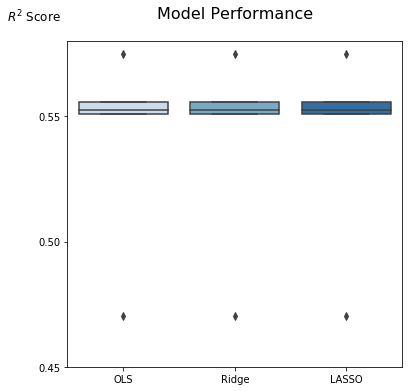

In [242]:
models = {'OLS':  LinearRegression(),
          'Ridge': Ridge(alpha = best_ridge_alpha),
          'LASSO': Lasso(alpha = best_lasso_alpha)}

scores_df = pd.DataFrame(columns = ['Model', 'Fold', 'Score'])

for model_idx, (model_name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores = cross_val_score(ridge_model, X_train, y_train, 
                                 cv=kf, scoring='r2')
    for score_idx, score in enumerate(scores):
        idx = model_idx*len(scores) + score_idx
        scores_df.loc[idx] = [model_name, score_idx, score]

plt.figure(figsize=(6,6));
sns.boxplot(x='Model', y='Score', data=scores_df, palette='Blues')
plt.yticks(np.arange(0.45, 0.60, 0.05));
plt.ylabel('$R^{2}$ Score', rotation = 0, fontsize = 12, y = 1.05);
plt.xlabel(None);
plt.title('Model Performance',fontsize = 16, y = 1.05);

Return to [Table of Contents](#table)

## 6. Results <a name="results"></a>

To interpret the beta coefficients, we first exponential transform the standard deviations of independent variables that were log transformed. <br> 
We then divide each feature's beta coefficient value by each feature's original standard deviation. <br>
Next, we must exponential transform our beta coefficients since we applied a log transform to the dependent variable. <br>

The results indicate that: <br>
- for every additional time an article is cited, an article increases its Altmetric score by 1.18 <br>
- for every additional institution involved, an article increases its Altmetric score by 1.05 <br>
- for every additional author that worked on the paper, an article increases its Altmetric score by 1.03 <br>
- for every additional reference used, an article increases its Altmetric score by 0.99 <br>
- for every additional year since publication, an article increases its Altmetric score by 0.66 <br>

The Altmetric score uses the number of citiations as a factor, so its helpful to note that it is the most important factor <br>
Obviously, some recommendations are more feasible than others. <br>
Using additional references and involving more people is one way to increase article impact, but it may minimize impact from personal contributions.

In [257]:
log_cols = ['num_times_cited', 'num_institutions', 'num_authors']

scales = list(zip(X.columns, scaler.scale_))
scales = [np.exp(scale[1]) if scale[0] in log_cols else scale[1] for scale in scales]

coefs = list(zip(X.columns, np.exp(lm.coef_/scales)))
coefs = sorted(coefs, key=lambda x:x[1], reverse = True)
coefs

[('num_times_cited', 1.1842106708711744),
 ('num_institutions', 1.0582395603307606),
 ('num_authors', 1.036570987172973),
 ('ref_cnt', 0.9968304032087043),
 ('year', 0.6643473212626814)]

We can also evaluate the linear model in terms of the assumptions of linear regression. <br>
It seems that we encounter heteroskedasticity for articles with much larger altmetric scores. <br>
The residuals appear normally distributed enough. <br>
This could help explain why the model had a decent, but not stellar $R^2$ value. 

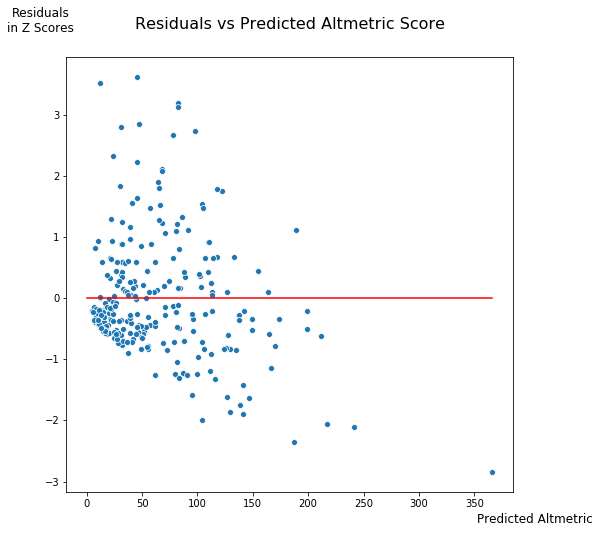

In [258]:
q1 = combined['altmetric'].quantile(.25)
q3 = combined['altmetric'].quantile(.75)
iqr = q3 - q1

lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr)

quartile_mask = combined['altmetric'].between(lower_bound, upper_bound, inclusive=True)
allowed_idx = combined.loc[quartile_mask, 'altmetric'].index
combined = combined[combined.index.isin(allowed_idx)]

df = combined.copy()
log_cols = ['altmetric', 'num_times_cited', 'num_institutions', 'num_authors']

for col in log_cols:
    if col == 'altmetric':
        df[col] = np.log(df[col] + 1)
    else:
        df[col] = np.log(df[col])

drop_cols = ['altmetric','other', 'top100', 'title_length', 
             'abstract_length','page_length', 'fig_count']        
        
X, y = df.drop(columns = drop_cols), df['altmetric']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


unscaled_y_pred = np.exp(y_pred)
unscaled_y_test = np.exp(y_test)
unscaled_resids = unscaled_y_test - unscaled_y_pred

resid_z_scores = (unscaled_resids-np.mean(unscaled_resids))/np.std(unscaled_resids)

plt.figure(figsize=(8,8))
sns.scatterplot(unscaled_y_pred, resid_z_scores);

plt.ylabel('Residuals\nin Z Scores', rotation = 0, fontsize = 12, y = 1.05);
plt.xlabel('Predicted Altmetric', fontsize=12, x=1.05);
plt.title('Residuals vs Predicted Altmetric Score',fontsize = 16, y = 1.05);
plt.plot([0, max(unscaled_y_pred)], [0, 0], linestyle="-", color='r');

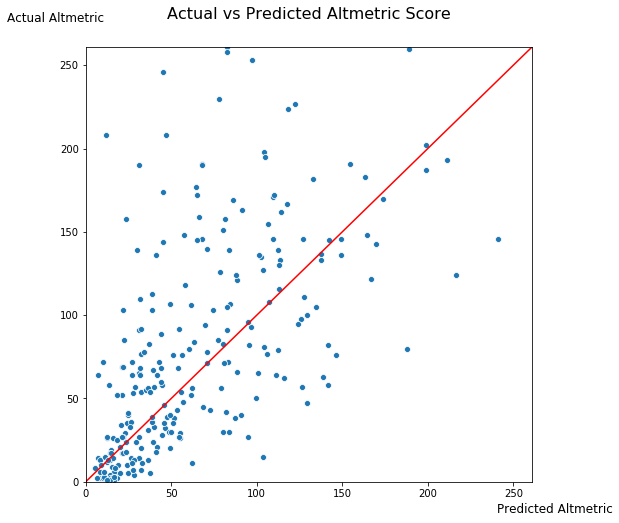

In [259]:
plt.figure(figsize=(8,8))
sns.scatterplot(unscaled_y_pred, unscaled_y_test);
plt.plot([0,max(unscaled_y_test)],[0, max(unscaled_y_test)], color='r');
plt.ylim([0, max(unscaled_y_test)]);
plt.xlim([0, max(unscaled_y_test)]);

plt.ylabel('Actual Altmetric', rotation = 0, fontsize = 12, y = 1.05);
plt.xlabel('Predicted Altmetric', fontsize=12, x=1.05);
plt.title('Actual vs Predicted Altmetric Score',fontsize = 16, y = 1.05);

Return to [Table of Contents](#table)